# Herron Topic 2 - Trading Strategies

This notebook covers trading strategies based on technical analysis in three parts:

1. What is technical analysis?
1. Why might trading strategies based on technical analysis work (or not work)?
1. Implement a simple moving average (SMA) trading strategy

The practice notebook will cover several other trading strategies based on technical analysis.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

## What is technical analysis?

[Technical analysis](https://en.wikipedia.org/wiki/Technical_analysis) is a methodology that analyzes past market data (e.g., past prices and volume) in an attempt to forecast future price movements.
If technical analysis can predict future price movements, the market is not weak-form efficient.
Ivo Welch provides the three degrees of market efficiency in section 12.2 of [chapter 12 of his free *Corporate Finance* textbook](https://book.ivo-welch.info/read/source5.mba/12-effbehav.pdf):

> The Traditional Classification
The traditional definition of market efficiency focuses on information. In the traditional classification, market efficiency comes in one of three primary degrees: weak,
semi-strong, and strong.
>
> **Weak market efficiency** says that all information in past prices is reflected in today’s
stock prices so that technical analysis (trading based solely on historical price
patterns) cannot be used to beat the market. Put differently, the market is the
best technical analyst.
>
> **Semistrong market efficiency** says that all public information is reflected in today’s
stock prices, so that neither fundamental trading (based on underlying firm
fundamentals, such as cash flows or discount rates) nor technical analysis can
be used to beat the market. Put differently, the market is both the best technical
and the best fundamental analyst.
>
> **Strong market efficiency** says that all information, both public and private, is reflected in today’s stock prices, so that nothing — not even private insider
information — can be used to beat the market. Put differently, the market is
the best analyst and cannot be beat.
> 
> In this traditional classification, all finance professors 
most U.S. financial markets are not strong-form efficient: Insider trading may be
illegal, but it works. However, there are still arguments as to which markets are only
semi-strong-form efficient or even only weak-form efficient.

Section 12.2 goes on to provide Welch's own taxonomy of true, firm, mild, and nonbelievers in market efficiency.
Chapter 12 summarizes market efficiency, classical finance, behavioral finance, arbitrage, limits to arbitrage, and their consequences for managers and investors.
We will focus on technical analysis in this notebook, but chapter 12 is excellent.

## Why might trading strategies based on technical analysis work or not?

### ...Work?

Technical analysis relies on a few ideas:

1. Market prices and volume reflect all relevant information, so we can focus on past prices and volume instead of fundamentals and news.
1. Market prices move in trends and patterns driven by market participants.
1. These trends and patterns tend to repeat themselves because market participants create them.

### ...Or Not?

The logic above is reasonable.
However, if past market prices reflect all relevant information, they should also reflect any prices trends they predict.
Therefore, any patterns should be self-defeating, and market prices should follow [a random walk](https://en.wikipedia.org/wiki/Random_walk_hypothesis).
As well, the signal-to-noise ratio in market prices is high!
Still, technical analysis provides an opportunity to learn how to implement and back-test trading strategies in Python.

#### A Random Walk

In a random walk, the price tomorrow equals the price today plus a tiny drift plus noise.
In math terms, a random walk is $P_{t} = \rho P_{t-1} + m P_{t-1} + \varepsilon$, where $E[\varepsilon] = 0$.
If $\rho > 1$, prices would quickly increase, and, if $\rho < 1$, prices would quickly decrease.
Let us examine the historical record.

In [3]:
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession()

In [4]:
ff = (
    pdr.DataReader(
        name='F-F_Research_Data_Factors_daily',
        data_source='famafrench',
        start='1900',
        session=session
    )
    [0]
    .assign(Mkt = lambda x: x['Mkt-RF'] + x['RF'])
    .div(100)
)

We can use market returns to impute market prices relative to the last day of June 1926.

In [5]:
price = ff['Mkt'].add(1).cumprod()

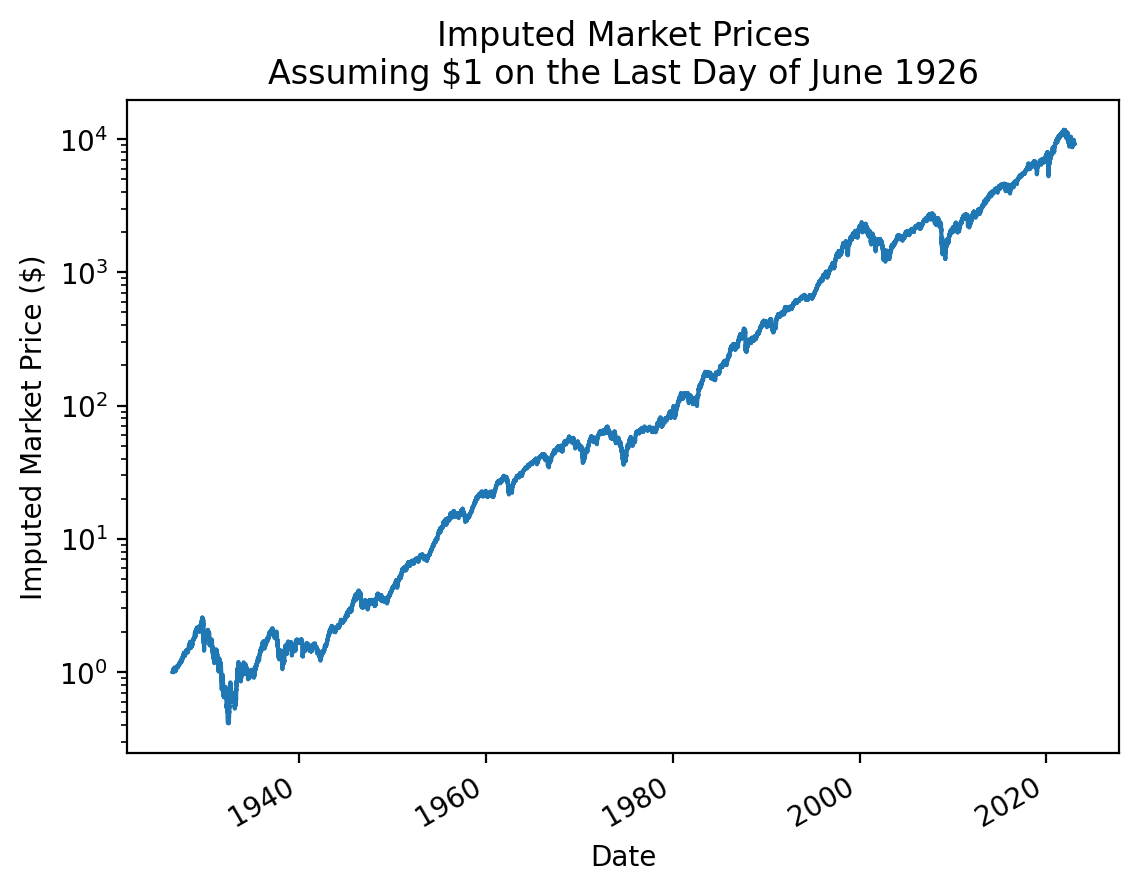

In [6]:
price.plot()
plt.title('Imputed Market Prices\nAssuming $1 on the Last Day of June 1926')
plt.ylabel('Imputed Market Price ($)')
plt.semilogy()
plt.show()

We need lagged prices to estimate $\rho$.
We will add 10 lags of $P$ to help us understand the relation between past and future prices.

In [7]:
price_lags = (
    pd.concat(
        objs=[price.shift(t) for t in range(11)],
        keys=[f'Lag {t}' for t in range(11)],
        names=['Price'],
        axis=1,
    )
)

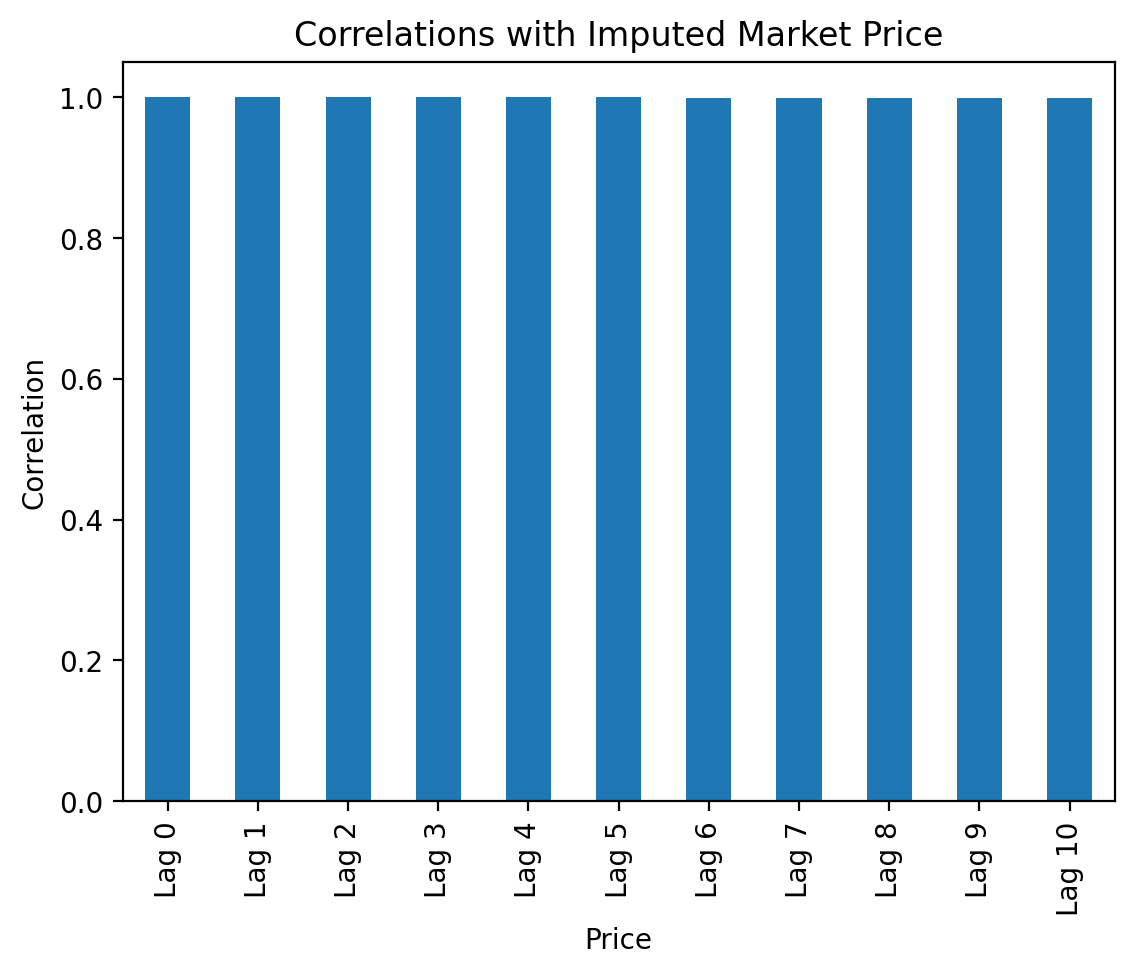

In [8]:
(
    price_lags
    .dropna()
    .corr()
    .loc['Lag 0']
    .plot(kind='bar')
)
plt.title('Correlations with Imputed Market Price')
plt.ylabel('Correlation')
plt.show()

But these are *pairwise* correlations.
If we estimate *conditional* correlations, we see that all the price information is in the first lag!

In [9]:
import statsmodels.api as sm

In [10]:
_ = price_lags.dropna()
y = _['Lag 0']
X = _.drop('Lag 0', axis=1).pipe(sm.add_constant)
model = sm.OLS(endog=y, exog=X)
fit = model.fit(cov_type='HAC', cov_kwds={'maxlags': 10})
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Lag 0   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.505e+06
Date:                Wed, 08 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:23:28   Log-Likelihood:            -1.1988e+05
No. Observations:               25389   AIC:                         2.398e+05
Df Residuals:                   25378   BIC:                         2.399e+05
Df Model:                          10                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1325      0.155      0.854      0.393      -0.171       0.436
Lag 1          0.9377      0.037     25.613      0.000       0.866       1.009
Lag 2          0.0918      0.064      1.445      0.148      -0.033       0.216
Lag 3         -0.0359      0.041     -0.880      0.379      -0.116       0.044
Lag 4         -0.0331      0.046     -0.714      0.475      -0.124       0.058
Lag 5          0.0473      0.042      1.122      0.262      -0.035       0.130
Lag 6         -0.0676      0.045     -1.504      0.133      -0.156       0.020
Lag 7          0.1294      0.052      2.478      0.013       0.027       0.232
Lag 8         -0.1415      0.059     -2.400      0.016      -0.257      -0.026
Lag 9          0.1608      0.050      3.236      0.001       0.063       0.258
Lag 10        -0.0887      0.034     -2.576      0.010      -0.156      -0.021
==============================================================================
Omnibus:                    17230.148   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6700094.359
Skew:                          -2.073   Prob(JB):                         0.00
Kurtosis:                      82.475   Cond. No.                     8.09e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 10 lags and without small sample correction
[2] The condition number is large, 8.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

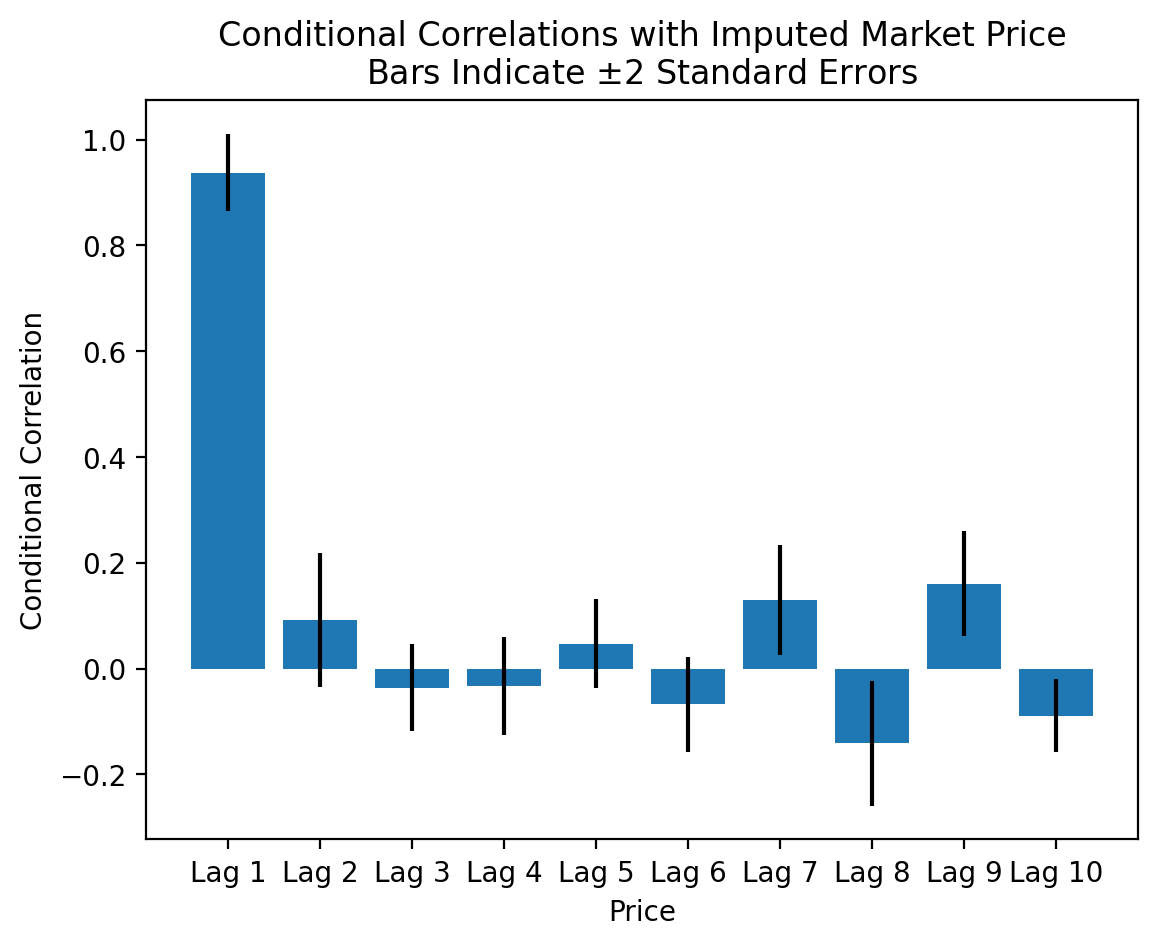

In [11]:
plt.bar(
    x=price_lags.columns[1:],
    height=fit.params[1:],
    yerr=2*fit.bse[1:]
)
plt.title('Conditional Correlations with Imputed Market Price\nBars Indicate $\pm 2$ Standard Errors')
plt.ylabel('Conditional Correlation')
plt.xlabel('Price')
plt.show()

#### Signal-to-Noise Ratio

Recall, we can express a random walk as $P_{t} = \rho P_{t-1} + m P_{t-1} + \varepsilon_t$.
Since $\rho = 1$, we can subtract $P_{t-1}$ from both sides, then divide by $P_{t-1}$ on both sides.
This transformation expresses a random walk in terms of returns: $r_{t-1,t} = m + e_t$, where $E[e_t] = 0$ and $SD[e_t] = s$, so $E[r_{t-1, t}] = m$.
We can think of the signal-to-noise ratio as $\frac{m}{s}$.
How high is this ratio?

In [12]:
m, s = ff['Mkt'].mean(), ff['Mkt'].std()

Here $m$ is about 4 basis points per day!

In [13]:
m

0.0004

However, $s$ is about 108 basis points per day!

In [14]:
s

0.0108

In [15]:
m/s

0.0386

Means grow linearly with time, while standard deviations growth with the square-root of time.
Therefore, even with a 1 basis point signal, we need a lot of data to make sure this 1 basis point signal is real!
For example, if we want $\sqrt{t} \times \frac{1}{s} \geq 2$, we need $t \geq \left(2 \times \frac{s}{1} \right)^2$ days!
Even with market noise, which is diversified and low, we need more than 100 years of data!

In [16]:
(2 * s / 0.0001)**2 / 365

128.4479

## Implement a simple moving average (SMA) trading strategy

One goal of technical analysis is to "buy low, and sell high".
The $n$-day SMA reduces noise in market prices, removing market fluctuations and providing estimates of "true" prices.
Market prices below their SMA might be buying opportunities, and market prices below their SMA might be selling opportunities.
Here, we will implement a long-only 20-day SMA (SMA(20)) strategy with Bitcoin:

1. Buy when the closing price crosses SMA(20) from below
1. Sell when the closing price crosses SMA(20) from above
1. No short-selling

Because we will not sell short, we can simplify this strategy to "long if above SMA(20), otherwise neutral".
First, we will need Bitcoin returns data.

In [17]:
import yfinance as yf

In [18]:
btc = (
    yf.download(tickers='BTC-USD', progress=False)
    .assign(
        Date = lambda x: x.index.tz_localize(None),
        Return = lambda x: x['Adj Close'].pct_change(),
    )
    .set_index('Date')
    .rename_axis(columns='Variable')
)

btc.head()

Variable,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2014-09-17,465.8640,468.1740,452.4220,457.3340,457.3340,21056800,NaN
2014-09-18,456.8600,456.8600,413.1040,424.4400,424.4400,34483200,-0.0719
2014-09-19,424.1030,427.8350,384.5320,394.7960,394.7960,37919700,-0.0698
2014-09-20,394.6730,423.2960,389.8830,408.9040,408.9040,36863600,0.0357
2014-09-21,408.0850,412.4260,393.1810,398.8210,398.8210,26580100,-0.0247


Next we:

1. Use `.rolling(20).mean()` to add a `SMA20` column containing SMA(20) to our `btc` data frame
1. Use `np.select()` to add a `Position` column containing:
    1. `1` (long) when the adjusted close is greater than SMA(20)
    1. `0` (neutral) when the adjusted close is less than (or equal to) SMA(20)
    1. We could use `np.where()` instead of `np.select()`, but using `np.select()` provides a more flexible framework for more complex examples
    1. **We use `.shift()` to compare yesterday's closing prices, avoiding a look-ahead bias**
1. Add a `Strategy` column containing:
    1. `Return` if `Position == 1`
    1. `0` if `Position == 0`
    1. We could earn the risk-free rate instead of 0 percent, but earning 0 percent simplifies this example

In [19]:
btc = (
    btc
    .assign(
        SMA20 = lambda x: x['Adj Close'].rolling(20).mean(),
        Position = lambda x: np.select(
            condlist=[x['Adj Close'].shift() > x['SMA20'].shift(), x['Adj Close'].shift() <= x['SMA20'].shift()],
            choicelist=[1, 0],
            default=np.nan
        ),
        Strategy = lambda x: x['Position'] * x['Return']
    )
)

I find it helpful to plot `Adj Close`, `SMA20`, and `Position` for a sort window with one or more crossings.

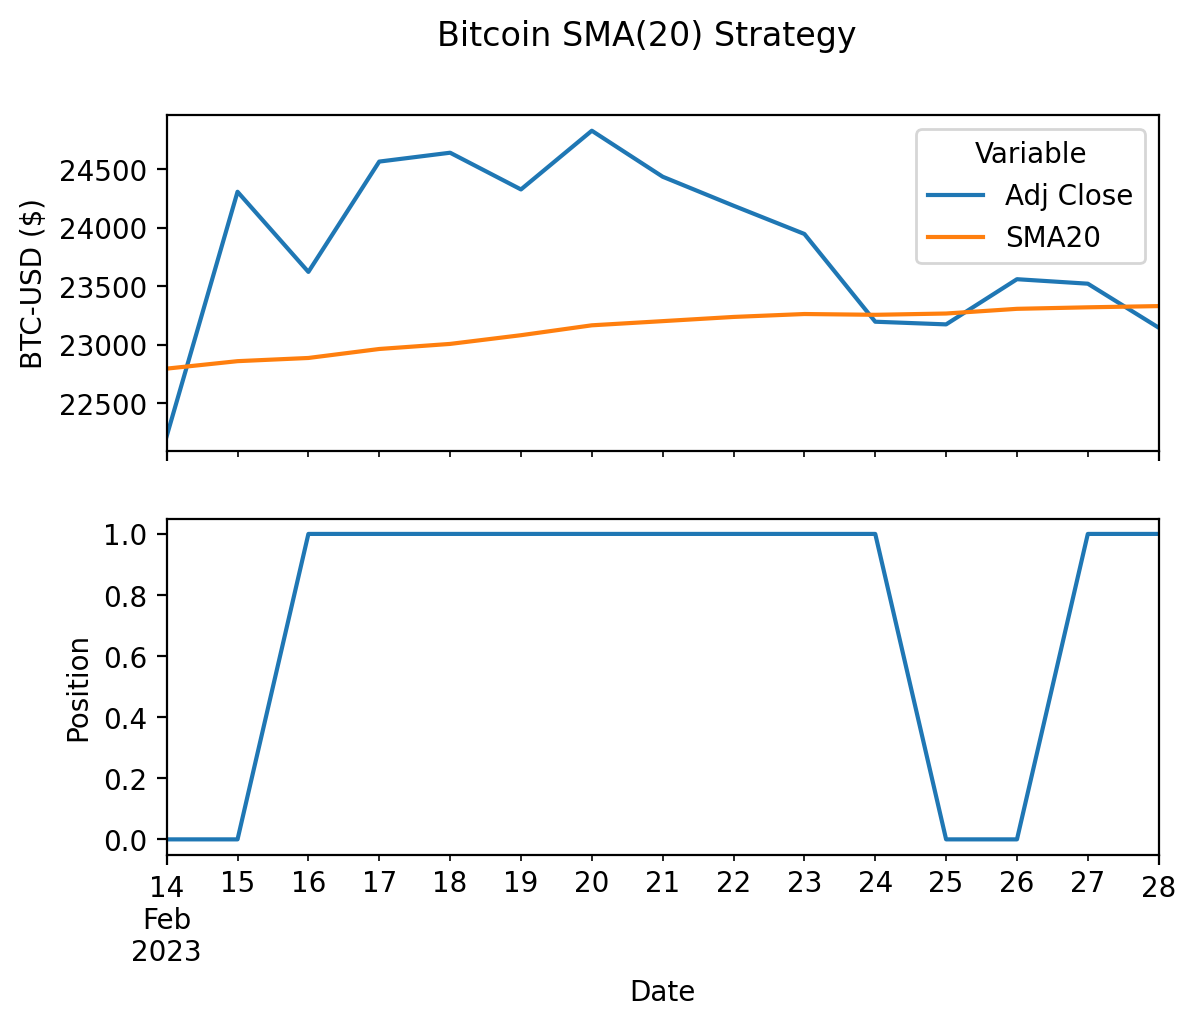

In [20]:
fig, ax = plt.subplots(2, 1, sharex=True)
_ = btc.loc['2023-02'].iloc[-15:]
_[['Adj Close', 'SMA20']].plot(ax=ax[0], ylabel='BTC-USD ($)')
_[['Position']].plot(ax=ax[1], ylabel='Position', legend=False)
plt.suptitle('Bitcoin SMA(20) Strategy')
plt.show()

We can compare the long-run performance of buy-and-hold and SMA(20).

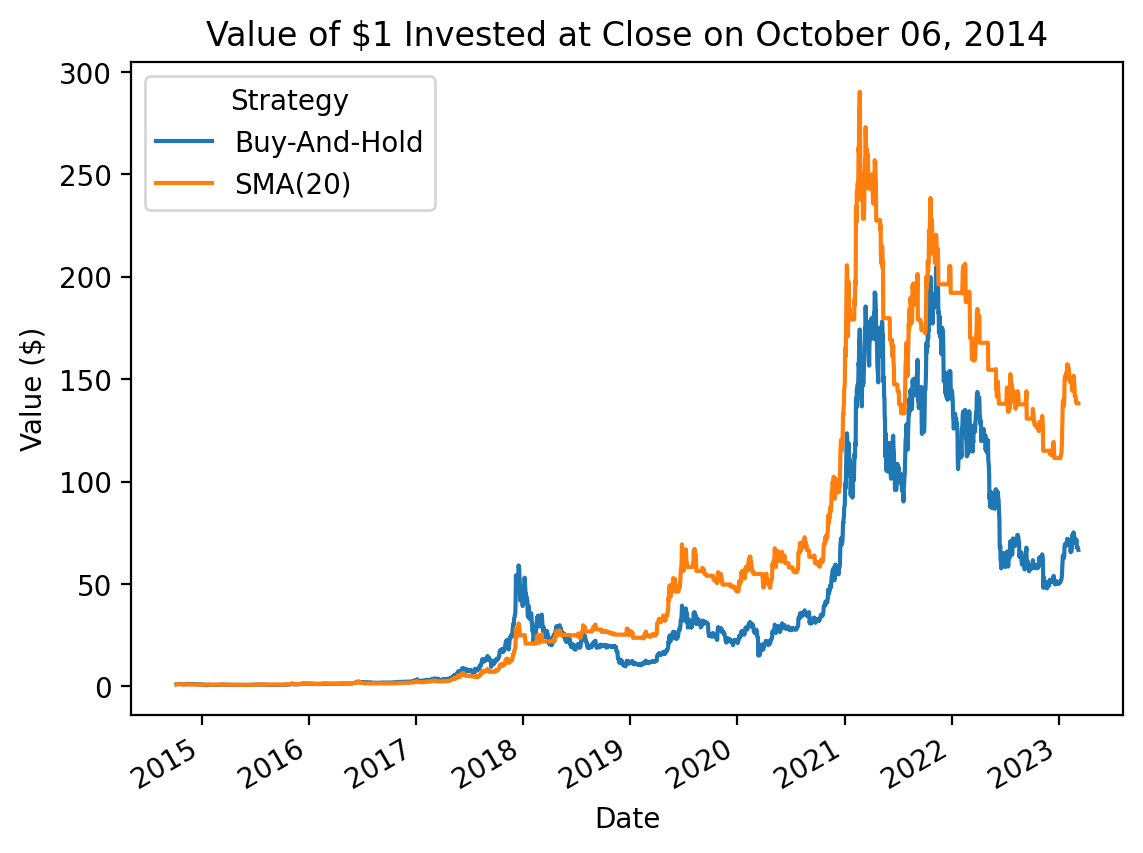

In [21]:
_ = btc[['Return', 'Strategy']].dropna()

(
    _
    .add(1)
    .cumprod()
    .rename_axis(columns='Strategy')
    .rename(columns={'Return': 'Buy-And-Hold', 'Strategy': 'SMA(20)'})
    .plot()
)
plt.ylabel('Value ($)')
plt.title(f'Value of $1 Invested at Close on {_.index[0] - pd.offsets.Day(1):%B %d, %Y}')
plt.show()

What about the rolling and full-sample Sharpe Ratios of these two strategies?
For simplicity, we will assume $R_F = 0$.

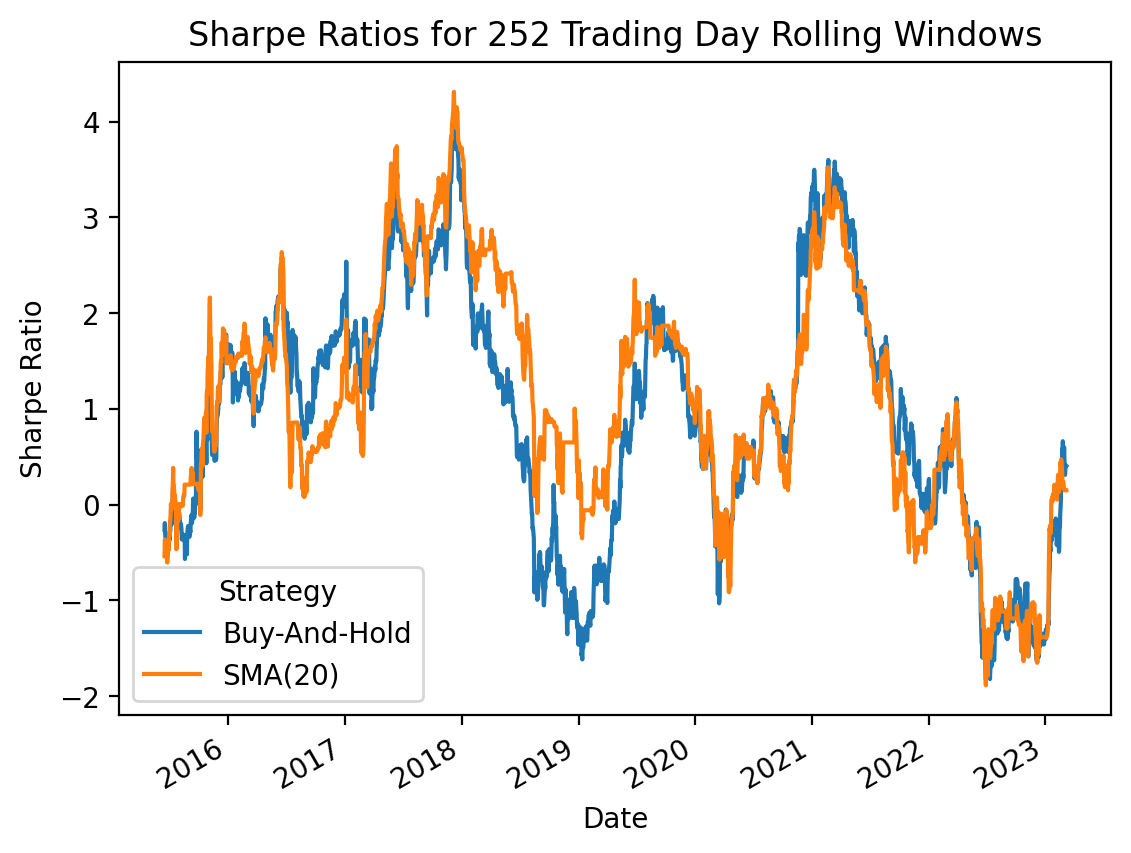

In [22]:
(
    btc
    [['Return', 'Strategy']]
    .dropna()
    .rolling(252)
    .apply(lambda x: np.sqrt(252) * x.mean() / x.std())
    .rename_axis(columns='Strategy')
    .rename(columns={'Return': 'Buy-And-Hold', 'Strategy': 'SMA(20)'})
    .plot()
)
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratios for 252 Trading Day Rolling Windows')
plt.show()

In [23]:
(
    btc
    [['Return', 'Strategy']]
    .dropna()
    .agg(lambda x: np.sqrt(252) * x.mean() / x.std())
    .rename_axis('Sharpe Ratio')
    .rename({'Return': 'Buy-And-Hold', 'Strategy': 'SMA(20)'})
)

Sharpe Ratio
Buy-And-Hold   0.8751
SMA(20)        1.1881
dtype: float64

In the practice notebook, we will dig deeper on this strategy and others.